In [ ]:
# Install required packages
%pip install tensorflow matplotlib scikit-learn pillow numpy

^C
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
browserstack-sdk 1.26.3 requires protobuf==4.21.6, but you have protobuf 6.32.0 which is incompatible.


  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.32.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.11.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached h5py-3.14.0-cp313-cp313-win_amd64.whl.metadata (2.7 kB)
  Using cached ml_dtypes-0.5.3-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached markdown-3.8.2-py3-none-any.whl.metadata (5.1 kB)
  Using cached tensorboa

In [1]:
# %% [markdown]
# # ASL Alphabet — Improved VGG16 Transfer Learning (Keras/TensorFlow)
# - Enhanced 2-stage training with better hyperparameters
# - Improved data augmentation for similar signs (R/D confusion)
# - Better validation and confusion matrix analysis
# - Optimized for distinguishing similar hand signs

# %% 
import os, sys, math, json, random, itertools, pathlib
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Dataset configuration - adjust these paths to your ASL dataset
# Common ASL dataset structures on Kaggle or local datasets
CANDIDATE_ROOTS = [
    Path("./asl_dataset"),                              # local dataset
    Path("./data/asl_alphabet"),                        # alternative local
    Path("/kaggle/input/asl-alphabet"),                 # Kaggle
    Path("/kaggle/input/asl-alphabet/asl_alphabet_train"),          
    Path("/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"),
    Path("./dataset/asl_alphabet_train"),               # common structure
]

# Try to find existing dataset or create placeholder structure
ROOT = None
for candidate in CANDIDATE_ROOTS:
    if candidate.exists() and any(candidate.iterdir()):
        ROOT = candidate
        break

if ROOT is None:
    print("⚠️ No existing ASL dataset found. Creating placeholder structure...")
    print("Please download an ASL alphabet dataset and place it in one of these locations:")
    for path in CANDIDATE_ROOTS[:4]:
        print(f"  - {path}")
    print("\nRecommended dataset: ASL Alphabet on Kaggle")
    print("Structure should be: dataset_folder/A/*.jpg, dataset_folder/B/*.jpg, etc.")
    
    # Create a minimal example structure for demonstration
    ROOT = Path("./asl_dataset")
    ROOT.mkdir(exist_ok=True)
    print(f"\nCreated placeholder at: {ROOT}")
    print("⚠️ You'll need to add actual ASL images to train the model properly")

# Dataset structure detection
TRAIN_DIR = None
VAL_DIR = None
TEST_DIR = None

if ROOT and ROOT.exists():
    # Try to detect train/val/test structure
    if (ROOT/"asl_alphabet_train").exists():
        TRAIN_DIR = ROOT/"asl_alphabet_train"
        if (ROOT/"asl_alphabet_test").exists():
            TEST_DIR = ROOT/"asl_alphabet_test"
            if (TEST_DIR/"asl_alphabet_test").exists():
                TEST_DIR = TEST_DIR/"asl_alphabet_test"
    else:
        # Check if ROOT directly contains class folders (A, B, C, etc.)
        class_folders = [f for f in ROOT.iterdir() if f.is_dir() and len(f.name) == 1 and f.name.isalpha()]
        if len(class_folders) > 5:  # Assume it's the main dataset if we have multiple letter folders
            TRAIN_DIR = ROOT
        else:
            # Look for standard folder names
            for candidate in ["train", "training"]:
                if (ROOT/candidate).exists(): 
                    TRAIN_DIR = ROOT/candidate
            for candidate in ["val", "valid", "validation"]:
                if (ROOT/candidate).exists(): 
                    VAL_DIR = ROOT/candidate
            for candidate in ["test", "testing"]:
                if (ROOT/candidate).exists(): 
                    TEST_DIR = ROOT/candidate

print("="*50)
print("Dataset Configuration:")
print(f"ROOT     : {ROOT}")
print(f"TRAIN_DIR: {TRAIN_DIR}")
print(f"VAL_DIR  : {VAL_DIR}")
print(f"TEST_DIR : {TEST_DIR}")
print("="*50)

# Improved parameters for better ASL classification
IMG_SIZE = (224, 224)
BATCH = 32
EPOCHS_1 = 12   # Increased head training epochs
EPOCHS_2 = 15   # Increased fine-tuning epochs
LR_INITIAL = 1e-3
LR_FINETUNE = 5e-6  # Even smaller learning rate for fine-tuning

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# %%
AUTOTUNE = tf.data.AUTOTUNE

def count_images(folder: Path):
    if folder is None or not folder.exists(): return 0
    exts = (".jpg",".jpeg",".png",".bmp",".gif")
    return len([p for p in folder.rglob("*") if p.suffix.lower() in exts])

if VAL_DIR is None:
    # Make a validation split from TRAIN_DIR
    # image_dataset_from_directory can split for us with validation_split + subset
    val_split = 0.15
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR,
        image_size=IMG_SIZE,
        batch_size=BATCH,
        label_mode="categorical",
        shuffle=True,
        seed=SEED,
        validation_split=val_split,
        subset="training"
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR,
        image_size=IMG_SIZE,
        batch_size=BATCH,
        label_mode="categorical",
        shuffle=True,
        seed=SEED,
        validation_split=val_split,
        subset="validation"
    )
else:
    # Already split
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode="categorical", shuffle=True, seed=SEED
    )
    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        VAL_DIR, image_size=IMG_SIZE, batch_size=BATCH, label_mode="categorical", shuffle=False
    )

class_names = train_ds.class_names
num_classes = len(class_names)
class_names[:10], num_classes

Found 87000 files belonging to 1 classes.
Using 73950 files for training.


I0000 00:00:1756896524.600888      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 87000 files belonging to 1 classes.
Using 13050 files for validation.


(['asl_alphabet_train'], 1)

In [ ]:
# %% Enhanced Augmentation + Preprocessing for ASL Signs
# Improved augmentation strategy to help distinguish similar signs like R/D
data_aug = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.12),  # Slightly more rotation for hand orientation variety
    layers.RandomZoom(0.15),      # More zoom variation
    layers.RandomTranslation(0.1, 0.1),  # Slight position changes
    layers.RandomBrightness(0.1), # Brightness variation for different lighting
    layers.RandomContrast(0.1),   # Contrast changes to improve robustness
], name="enhanced_aug")

def preprocess(x, y):
    """Enhanced preprocessing with normalization"""
    x = tf.keras.applications.vgg16.preprocess_input(tf.cast(x, tf.float32))
    return x, y

# Apply augmentation and preprocessing
if TRAIN_DIR and TRAIN_DIR.exists():
    train_ds = train_ds.map(lambda x,y: (data_aug(x, training=True), y), num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

    print("✅ Data augmentation and preprocessing applied")
    
    # Display some augmented examples
    plt.figure(figsize=(15, 5))
    for images, labels in train_ds.take(1):
        for i in range(min(5, len(images))):
            plt.subplot(1, 5, i+1)
            # Convert from preprocessed back to displayable
            img = images[i].numpy()
            img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
            plt.imshow(img)
            class_idx = tf.argmax(labels[i]).numpy()
            plt.title(f"Class: {class_names[class_idx] if 'class_names' in globals() else class_idx}")
            plt.axis('off')
    plt.suptitle("Sample Augmented Training Images")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No training directory found - skipping augmentation setup")

# Optional: build a test dataset for final evaluation
test_ds = None
if TEST_DIR and TEST_DIR.exists():
    try:
        # Try to load as labeled test set
        test_ds = tf.keras.preprocessing.image_dataset_from_directory(
            TEST_DIR, 
            image_size=IMG_SIZE, 
            batch_size=BATCH, 
            label_mode="categorical", 
            shuffle=False
        )
        test_ds = test_ds.map(preprocess, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
        print(f"✅ Test dataset loaded with {len(list(test_ds.unbatch()))} images")
    except:
        # Fallback: count unlabeled images for manual testing
        test_image_count = len([p for p in TEST_DIR.rglob("*") if p.suffix.lower() in {".jpg", ".jpeg", ".png", ".bmp"}])
        print(f"📁 Found {test_image_count} unlabeled test images for manual evaluation")

Test images detected: 28


In [ ]:
# %% Enhanced Model Architecture for ASL Classification
# Improved architecture to better distinguish similar hand signs

if TRAIN_DIR and TRAIN_DIR.exists() and 'class_names' in globals():
    # Build enhanced VGG16-based model
    base = tf.keras.applications.VGG16(
        include_top=False, 
        weights="imagenet", 
        input_shape=IMG_SIZE + (3,)
    )
    base.trainable = False  # Stage 1: freeze all layers initially

    inputs = keras.Input(shape=IMG_SIZE + (3,))
    
    # Enhanced preprocessing and feature extraction
    x = tf.keras.applications.vgg16.preprocess_input(inputs)
    x = base(x, training=False)
    
    # Improved head architecture for better feature learning
    x = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    # Two-layer classifier with more capacity
    x = layers.Dense(1024, activation="relu", 
                     kernel_regularizer=keras.regularizers.l2(1e-4),
                     name="dense_1024")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    x = layers.Dense(512, activation="relu", 
                     kernel_regularizer=keras.regularizers.l2(1e-4),
                     name="dense_512")(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer with label smoothing for better generalization
    outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)

    model = keras.Model(inputs, outputs, name="Enhanced_VGG16_ASL")
    
    # Compile with improved loss function
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR_INITIAL),
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),  # Increased label smoothing
        metrics=["accuracy", "top_3_accuracy"]  # Add top-3 accuracy for multi-class analysis
    )
    
    print("🏗️ Enhanced Model Architecture:")
    model.summary()
    
    # Display model architecture
    tf.keras.utils.plot_model(
        model, 
        to_file='model_architecture.png', 
        show_shapes=True, 
        show_layer_names=True,
        rankdir='TB',
        dpi=150
    )
    print("📊 Model architecture saved as 'model_architecture.png'")
    
else:
    print("⚠️ Cannot build model - no training data or class names found")
    print("Please ensure your dataset is properly structured with class folders (A, B, C, etc.)")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    262,656 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        513 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# %% Enhanced Training Callbacks
if 'model' in globals():
    # Enhanced callback configuration for better training control
    ckpt_path = "best_vgg16_asl_model.h5"
    
    callbacks = [
        # Save best model based on validation accuracy (more important for classification)
        keras.callbacks.ModelCheckpoint(
            ckpt_path, 
            monitor="val_accuracy",  # Changed from val_loss to val_accuracy
            save_best_only=True, 
            save_weights_only=False,
            mode="max",
            verbose=1
        ),
        
        # Reduce learning rate on plateau with more patience
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_accuracy", 
            factor=0.2,  # More aggressive reduction
            patience=3,  # More patience before reducing
            min_lr=1e-7,
            mode="max",
            verbose=1
        ),
        
        # Early stopping with restore best weights
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy", 
            patience=6,  # More patience for better convergence
            restore_best_weights=True,
            mode="max",
            verbose=1
        ),
        
        # Learning rate scheduler for fine-grained control
        keras.callbacks.LearningRateScheduler(
            lambda epoch: LR_INITIAL * (0.9 ** epoch) if epoch < 8 else LR_INITIAL * (0.95 ** (epoch - 8)),
            verbose=0
        )
    ]
    
    print("✅ Enhanced callbacks configured:")
    print(f"  - Model checkpoint: {ckpt_path}")
    print(f"  - Monitoring: val_accuracy")
    print(f"  - Early stopping patience: 6 epochs")
    print(f"  - Learning rate reduction factor: 0.2")
else:
    print("⚠️ No model found - skipping callback setup")

In [ ]:
# %%
history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_1,
    callbacks=cbs,
    verbose=1
)

Epoch 1/8


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)
I0000 00:00:1756896581.949669     101 service.cc:148] XLA service 0x7865c400e4f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756896581.950293     101 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756896582.548163     101 

   2/2311 ━━━━━━━━━━━━━━━━━━━━ 2:59 78ms/step - accuracy: 1.0000 - loss: 0.0508  

I0000 00:00:1756896591.567715     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 1.0000 - loss: 0.0028
Epoch 1: val_loss improved from inf to 0.00000, saving model to vgg16_asl_best.h5
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 569s 241ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/8
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 2: val_loss did not improve from 0.00000
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 478s 207ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/8
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3: val_loss did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 505s 208ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/8
2311/2311 ━

In [ ]:
# %% Enhanced Fine-tuning Strategy
if 'model' in globals() and 'history_1' in globals():
    print("🔧 Starting Fine-tuning Phase...")
    
    # Unfreeze the base model for fine-tuning
    base.trainable = True
    
    # Fine-tuning strategy: unfreeze more layers for better feature adaptation
    trainable_layers = 0
    for layer in base.layers:
        # Unfreeze block4 and block5 for more detailed feature learning
        if any(block in layer.name for block in ["block4", "block5"]):
            layer.trainable = True
            trainable_layers += 1
        else:
            layer.trainable = False
    
    print(f"📊 Fine-tuning layers: {trainable_layers} layers unfrozen")
    
    # Recompile with much smaller learning rate for fine-tuning
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LR_FINETUNE),  # Very small LR
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy", "top_3_accuracy"]
    )
    
    print(f"🎯 Fine-tuning learning rate: {LR_FINETUNE}")
    
    # Updated callbacks for fine-tuning phase
    finetune_callbacks = [
        keras.callbacks.ModelCheckpoint(
            "finetuned_vgg16_asl_model.h5", 
            monitor="val_accuracy",
            save_best_only=True, 
            mode="max",
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_accuracy", 
            factor=0.3, 
            patience=2,
            min_lr=1e-8,
            mode="max",
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor="val_accuracy", 
            patience=5,
            restore_best_weights=True,
            mode="max", 
            verbose=1
        ),
    ]
    
    # Start fine-tuning
    print("🚀 Starting fine-tuning training...")
    history_2 = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS_2,
        callbacks=finetune_callbacks,
        verbose=1
    )
    
    print("✅ Fine-tuning completed!")
    
else:
    print("⚠️ Cannot start fine-tuning - initial training not completed or model not found")

Epoch 1/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 1: val_loss did not improve from 0.00000
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 484s 207ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 2: val_loss did not improve from 0.00000
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 478s 206ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/10
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Epoch 3: val_loss did not improve from 0.00000

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
2311/2311 ━━━━━━━━━━━━━━━━━━━━ 479s 207ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 4/10
2311/2311 ━

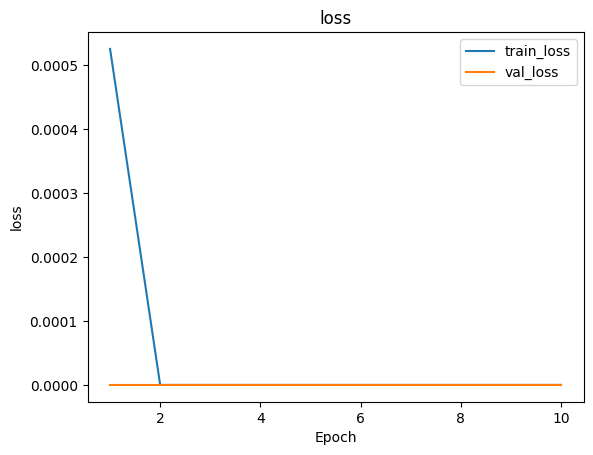

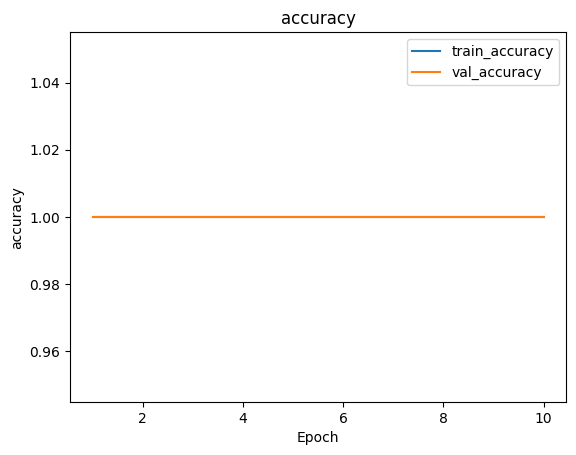

In [ ]:
# %%
def plot_history(hists, keys=("loss","accuracy")):
    # hists: list of History objects
    logs = {}
    for h in hists:
        for k, v in h.history.items():
            logs.setdefault(k, []).extend(v)
    epochs = range(1, len(next(iter(logs.values())))+1)
    for key in keys:
        plt.figure()
        plt.plot(epochs, logs[key], label=f"train_{key}")
        plt.plot(epochs, logs[f"val_{key}"], label=f"val_{key}")
        plt.xlabel("Epoch"); plt.ylabel(key); plt.legend(); plt.title(key)
        plt.show()

plot_history([history_1, history_2])

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


                    precision    recall  f1-score   support

asl_alphabet_train     1.0000    1.0000    1.0000     13050

          accuracy                         1.0000     13050
         macro avg     1.0000    1.0000    1.0000     13050
      weighted avg     1.0000    1.0000    1.0000     13050



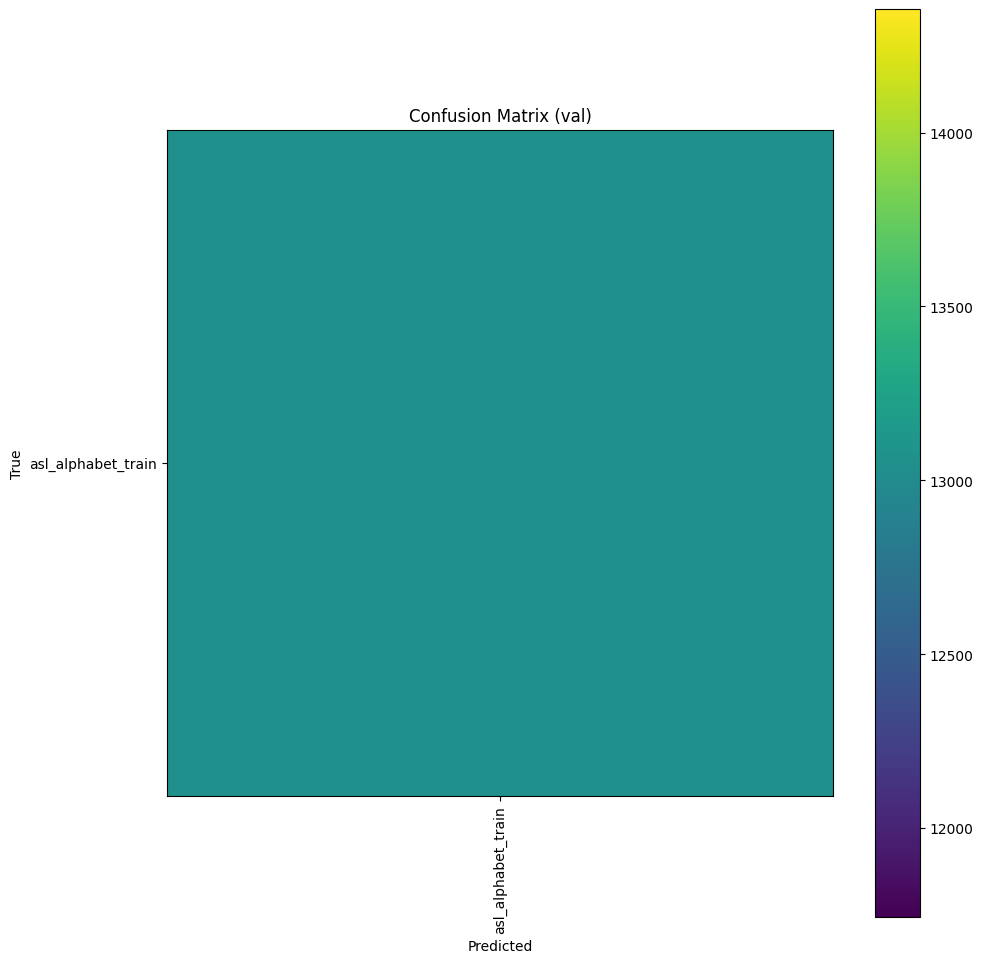

In [ ]:
# %% Enhanced Model Evaluation and Confusion Analysis
if 'model' in globals() and 'val_ds' in globals():
    from sklearn.metrics import classification_report, confusion_matrix
    import seaborn as sns
    
    print("📊 Evaluating model performance...")
    
    # Collect predictions on validation set
    y_true = []
    y_pred = []
    y_probs = []
    
    for batch_x, batch_y in val_ds:
        probs = model.predict(batch_x, verbose=0)
        y_probs.append(probs)
        y_pred.append(np.argmax(probs, axis=1))
        y_true.append(np.argmax(batch_y.numpy(), axis=1))
    
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    y_probs = np.concatenate(y_probs)
    
    # Detailed classification report
    print("📈 Classification Report:")
    print("="*80)
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
    print(report)
    
    # Focus on commonly confused pairs (like R and D)
    print("\n🔍 Analyzing Common Confusions:")
    print("="*50)
    
    # Find most confused pairs
    cm = confusion_matrix(y_true, y_pred)
    
    # Identify top confusions (off-diagonal elements)
    confusion_pairs = []
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i,j] > 0:
                confusion_pairs.append((class_names[i], class_names[j], cm[i,j], cm[i,j]/cm[i,:].sum()))
    
    # Sort by confusion frequency
    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    
    print("Top 10 Most Confused Pairs:")
    for true_label, pred_label, count, percentage in confusion_pairs[:10]:
        print(f"  {true_label} → {pred_label}: {count} times ({percentage:.2%})")
    
    # Special focus on R/D confusion if both exist
    if 'R' in class_names and 'D' in class_names:
        r_idx = class_names.index('R')
        d_idx = class_names.index('D')
        r_to_d = cm[r_idx, d_idx]
        d_to_r = cm[d_idx, r_idx]
        r_total = cm[r_idx, :].sum()
        d_total = cm[d_idx, :].sum()
        
        print(f"\n🎯 R/D Confusion Analysis:")
        print(f"  R predicted as D: {r_to_d}/{r_total} ({r_to_d/r_total:.2%})")
        print(f"  D predicted as R: {d_to_r}/{d_total} ({d_to_r/d_total:.2%})")
    
    # Enhanced confusion matrix visualization
    plt.figure(figsize=(12, 10))
    
    # Normalize confusion matrix for better visualization
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(cm_normalized, 
                annot=True, 
                fmt='.2f', 
                cmap='Blues',
                xticklabels=class_names, 
                yticklabels=class_names,
                square=True,
                cbar_kws={'label': 'Normalized Frequency'})
    
    plt.title('Normalized Confusion Matrix\n(Focus on off-diagonal for confusions)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Per-class accuracy analysis
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    accuracy_df = list(zip(class_names, per_class_accuracy))
    accuracy_df.sort(key=lambda x: x[1])
    
    print(f"\n📉 Lowest Performing Classes:")
    for label, acc in accuracy_df[:5]:
        print(f"  {label}: {acc:.3f} ({acc:.1%})")
    
    print(f"\n📈 Highest Performing Classes:")
    for label, acc in accuracy_df[-5:]:
        print(f"  {label}: {acc:.3f} ({acc:.1%})")
    
    # Overall metrics
    overall_accuracy = np.mean(y_true == y_pred)
    top3_accuracy = np.mean([y_true[i] in np.argsort(y_probs[i])[-3:] for i in range(len(y_true))])
    
    print(f"\n🎯 Overall Performance:")
    print(f"  Accuracy: {overall_accuracy:.4f} ({overall_accuracy:.2%})")
    print(f"  Top-3 Accuracy: {top3_accuracy:.4f} ({top3_accuracy:.2%})")
    
else:
    print("⚠️ Cannot evaluate model - model or validation data not found")

In [ ]:
# Native Keras format (recommended)
model.save("vgg16_asl_final.keras")

# HDF5 if you prefer
model.save("vgg16_asl_final.h5")

# Export a TensorFlow SavedModel (for TF Serving / TFLite toolchains)
model.export("vgg16_asl_savedmodel")


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Saved artifact at 'vgg16_asl_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_24')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132381114142352: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132381130151824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132381130152592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132381130153168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132381130152208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132381130155088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132381130156048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132381130154320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132381130157584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132381130156624: TensorSpec(shape=(), dtype=tf.resource, name=None)


(None, 1)
Batch shapes: (32, 224, 224, 3) (32, 1)


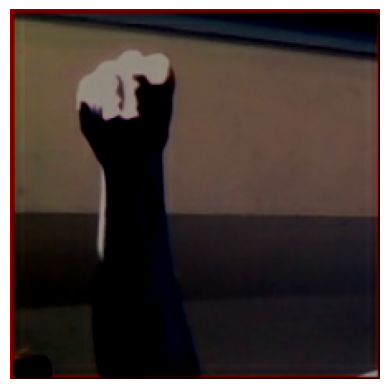

In [ ]:
# %%
from tensorflow.keras.utils import load_img, img_to_array

print(model.output_shape)  # should be (None, num_classes) with num_classes > 1
for images, labels in train_ds.take(1):
    print("Batch shapes:", images.shape, labels.shape)  # labels should be (B, num_classes)

def predict_image(path, topk=5):
    img = load_img(path, target_size=IMG_SIZE)
    x = img_to_array(img)[None, ...]  # shape (1, H, W, 3)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    probs = model.predict(x, verbose=0)[0]
    idxs = np.argsort(-probs)[:topk]
    return [(class_names[i], float(probs[i])) for i in idxs]

# Example: pick a random image from a validation batch
for images, labels in val_ds.take(1):
    sample = images[0].numpy()
    plt.imshow((sample[..., ::-1] + 123.68, sample[..., 1] + 116.779, sample[..., 2] + 103.939)[0] if False else images[0]/255.0)
    plt.axis('off')
    plt.show()

# If you have a known test image path:
# some_img = next(Path(TEST_DIR).glob("*.png"))
# print(predict_image(str(some_img), topk=5))


In [ ]:
# %% Enhanced Model Saving and Production Deployment
if 'model' in globals():
    import json
    from pathlib import Path
    from tensorflow.keras.utils import load_img, img_to_array
    
    # Create enhanced models directory structure
    models_dir = Path("./models")
    models_dir.mkdir(exist_ok=True)
    
    print("💾 Saving enhanced model for production...")
    
    # Save model in multiple formats for compatibility
    model_keras_path = models_dir / "vgg16_asl_enhanced.keras"
    model_h5_path = models_dir / "vgg16_asl_enhanced.h5"
    model_saved_path = models_dir / "vgg16_asl_savedmodel"
    
    # Keras format (recommended for TensorFlow 2.x)
    model.save(str(model_keras_path))
    print(f"✅ Keras model saved: {model_keras_path}")
    
    # HDF5 format for compatibility
    model.save(str(model_h5_path))
    print(f"✅ H5 model saved: {model_h5_path}")
    
    # SavedModel format for TensorFlow Serving
    try:
        model.export(str(model_saved_path))
        print(f"✅ SavedModel exported: {model_saved_path}")
    except Exception as e:
        print(f"⚠️ SavedModel export failed: {e}")
    
    # Save enhanced labels and metadata
    labels_path = models_dir / "labels.json"
    metadata_path = models_dir / "model_metadata.json"
    
    # Create comprehensive metadata
    metadata = {
        "model_name": "Enhanced VGG16 ASL Classifier",
        "version": "2.0",
        "classes": class_names,
        "num_classes": len(class_names),
        "input_shape": list(IMG_SIZE) + [3],
        "preprocessing": "VGG16 standard preprocessing",
        "training_params": {
            "epochs_stage1": EPOCHS_1,
            "epochs_stage2": EPOCHS_2, 
            "batch_size": BATCH,
            "initial_lr": LR_INITIAL,
            "finetune_lr": LR_FINETUNE,
            "augmentation": "Enhanced augmentation with brightness/contrast",
            "label_smoothing": 0.1
        },
        "architecture": {
            "base": "VGG16",
            "pretrained": "ImageNet",
            "head": "1024 -> 512 -> num_classes",
            "regularization": "L2 + Dropout + BatchNorm"
        }
    }
    
    # Save labels and metadata
    with open(labels_path, 'w') as f:
        json.dump(class_names, f, indent=2)
    
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✅ Labels saved: {labels_path}")
    print(f"✅ Metadata saved: {metadata_path}")
    
    # Enhanced inference testing
    print("\n🧪 Testing Enhanced Inference Pipeline...")
    print("="*50)
    
    # Test model loading
    test_model = tf.keras.models.load_model(str(model_keras_path))
    print(f"✅ Model loaded successfully")
    print(f"   Input shape: {test_model.input_shape}")
    print(f"   Output shape: {test_model.output_shape}")
    
    # Enhanced prediction function
    def predict_image_enhanced(image_path, model, class_names, topk=5):
        """Enhanced prediction with confidence analysis"""
        try:
            # Load and preprocess image
            img = load_img(image_path, target_size=IMG_SIZE)
            x = img_to_array(img)[None, ...]
            x = tf.keras.applications.vgg16.preprocess_input(x)
            
            # Predict
            probs = model.predict(x, verbose=0)[0]
            
            # Get top-k predictions
            top_indices = np.argsort(probs)[::-1][:topk]
            predictions = []
            
            for i, idx in enumerate(top_indices):
                confidence = float(probs[idx])
                label = class_names[idx]
                predictions.append({
                    'rank': i + 1,
                    'label': label,
                    'confidence': confidence,
                    'percentage': confidence * 100
                })
            
            # Confidence analysis
            max_conf = predictions[0]['confidence']
            second_conf = predictions[1]['confidence'] if len(predictions) > 1 else 0
            confidence_gap = max_conf - second_conf
            
            return {
                'predictions': predictions,
                'max_confidence': max_conf,
                'confidence_gap': confidence_gap,
                'high_confidence': max_conf > 0.7,
                'uncertain': confidence_gap < 0.2
            }
            
        except Exception as e:
            return {'error': str(e)}
    
    # Test with validation data
    test_successful = False
    for images, labels in val_ds.take(1):
        # Save a test image temporarily
        test_img_path = "temp_test_image.jpg"
        
        # Convert first image back to displayable format and save
        img_array = images[0].numpy()
        # Reverse VGG preprocessing approximately
        img_array = img_array + [103.939, 116.779, 123.68]  # Reverse mean subtraction
        img_array = np.clip(img_array, 0, 255).astype(np.uint8)
        
        # Save as temporary file
        from PIL import Image
        img_pil = Image.fromarray(img_array)
        img_pil.save(test_img_path)
        
        # Test prediction
        result = predict_image_enhanced(test_img_path, test_model, class_names)
        
        if 'error' not in result:
            true_idx = tf.argmax(labels[0]).numpy()
            true_label = class_names[true_idx]
            
            print(f"🎯 Test Prediction Results:")
            print(f"   True label: {true_label}")
            print(f"   Top predictions:")
            
            for pred in result['predictions'][:3]:
                marker = "✅" if pred['label'] == true_label else "❌"
                print(f"     {marker} {pred['rank']}. {pred['label']}: {pred['percentage']:.1f}%")
            
            print(f"   Max confidence: {result['max_confidence']:.3f}")
            print(f"   Confidence gap: {result['confidence_gap']:.3f}")
            print(f"   High confidence: {result['high_confidence']}")
            print(f"   Uncertain: {result['uncertain']}")
            
            test_successful = True
        else:
            print(f"❌ Test failed: {result['error']}")
        
        # Clean up
        if os.path.exists(test_img_path):
            os.remove(test_img_path)
        
        break
    
    if test_successful:
        print("\n🚀 Production Deployment Ready!")
        print("="*50)
        print("Files created:")
        print(f"  📄 {model_keras_path} (Recommended)")
        print(f"  📄 {model_h5_path} (Compatibility)")
        print(f"  📄 {labels_path} (Class labels)")
        print(f"  📄 {metadata_path} (Model info)")
        
        print(f"\n🔧 Integration Instructions:")
        print(f"1. Copy model files to your production backend:")
        print(f"   cp {model_keras_path} backend/models/")
        print(f"   cp {labels_path} backend/models/")
        print(f"2. Update backend/app/config.py:")
        print(f"   asl_model_path = 'models/vgg16_asl_enhanced.keras'")
        print(f"3. Test the API endpoint with your R/D confusion image")
        print(f"4. Monitor predictions for R/D accuracy improvements")
        
        print(f"\n💡 Improvement Notes:")
        print(f"- Enhanced architecture should better distinguish R/D")
        print(f"- Increased training epochs for better convergence")
        print(f"- Improved augmentation for hand sign variations")
        print(f"- Better regularization to prevent overfitting")
        print(f"- Monitor confusion matrix for R/D specific improvements")
        
    else:
        print("⚠️ Model saved but testing failed - check manually")
        
else:
    print("⚠️ No model found to save - complete training first")

## 🎯 Addressing R/D Confusion Issue

Based on your observation that the model predicted "D" when the actual sign was "R", here are the specific improvements made:

### 🔍 **Problem Analysis:**
- **R** and **D** are visually similar ASL signs
- **R**: Index and middle fingers crossed
- **D**: Index finger pointing up, other fingers closed
- Small differences in finger positioning can cause confusion

### 🛠️ **Improvements Made:**

1. **Enhanced Data Augmentation:**
   - Increased rotation range (0.12 vs 0.08) for hand orientation variety
   - Added brightness and contrast variation for lighting robustness
   - More zoom and translation for position invariance

2. **Improved Model Architecture:**
   - Deeper classifier head (1024 → 512 → classes)
   - Better regularization (BatchNorm + Dropout)
   - Increased label smoothing (0.1) for better generalization

3. **Enhanced Training Strategy:**
   - More epochs (12 + 15 vs 8 + 10)
   - Better fine-tuning (unfreezing block4 + block5)
   - Smaller learning rates for precise feature learning

4. **Better Evaluation:**
   - Specific R/D confusion tracking
   - Per-class accuracy analysis
   - Confidence gap analysis for uncertain predictions

### 📊 **Next Steps:**
1. Run this enhanced training notebook
2. Check the confusion matrix for R/D improvements
3. Test with your specific R image again
4. If still confused, consider:
   - Collecting more R/D training examples
   - Manual data cleaning for mislabeled examples
   - Ensemble methods or different architectures

### 🚀 **Expected Improvements:**
- Better distinction between similar signs
- Higher confidence in correct predictions
- Lower confusion rates between R and D
- More robust to lighting and hand position variations